In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

/Users/regan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

In [6]:
def add_features(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    
    df['item_monthly_avg'] = df.groupby(['item', 'month'])['sales'].transform('mean').astype(np.int64)
    df['store_monthly_avg'] = df.groupby(['store', 'month'])['sales'].transform('mean').astype(np.int64)
    df['item_yearly_avg'] = df.groupby(['item', 'year'])['sales'].transform('mean').astype(np.int64)
    df['store_yearly_avg'] = df.groupby(['store', 'year'])['sales'].transform('mean').astype(np.int64)
    return df

In [7]:
def calculate_smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

### Simple prediction using dayOfWeek and month for prediction

In [8]:
train = add_features(train)

In [9]:
# split train and validation sets
df_test = train[train["date"] >= "2017-10-01"]
df_train = train[train["date"] < "2017-10-01"]

print(df_train.shape)
print(df_test.shape)

x_train = df_train.drop(columns=["sales"])
y_train = df_train["sales"]
x_test = df_test.drop(columns=["sales"])
y_test = df_test["sales"]

(867000, 13)
(46000, 13)


In [10]:
df_train

date  store  item  sales  day  month  year  dayofweek  quarter  \
0      2013-01-01      1     1     13    1      1  2013          1        1   
1      2013-01-02      1     1     11    2      1  2013          2        1   
2      2013-01-03      1     1     14    3      1  2013          3        1   
3      2013-01-04      1     1     13    4      1  2013          4        1   
4      2013-01-05      1     1     10    5      1  2013          5        1   
...           ...    ...   ...    ...  ...    ...   ...        ...      ...   
912903 2017-09-26     10    50     79   26      9  2017          1        3   
912904 2017-09-27     10    50     80   27      9  2017          2        3   
912905 2017-09-28     10    50     82   28      9  2017          3        3   
912906 2017-09-29     10    50     90   29      9  2017          4        3   
912907 2017-09-30     10    50    103   30      9  2017          5        3   

        item_monthly_avg  store_monthly_avg  item_yearly_avg  store_yearly_avg  
0                     14                 32               18                39  
1                     14                 32               18                39  
2                     14                 32               18                39  
3                     14                 32               18                39  
4                     14                 32               18                39  
...                  ...                ...              ...               ...  
912903                69                 61               73                66  
912904                69                 61               73                66  
912905                69                 61               73                66  
912906                69                 61               73                66  
912907                69                 61               73                66  

[867000 rows x 13 columns]

In [15]:
# Create a MultiIndex from the 'item', 'store', 'dayofweek', and 'month' columns
multi_index = pd.MultiIndex.from_frame(x_train[['item', 'store', 'day', 'month']])

# Group the training data by this multi-index and calculate the mean sales
mean_sales = df_train.groupby(multi_index)['sales'].mean()

# Now create a multi-index from the test set in the same way
test_multi_index = pd.MultiIndex.from_frame(x_test[['item', 'store', 'day', 'month']])

# Use the multi-index to align and extract the corresponding mean sales
preds_train = mean_sales.loc[multi_index].values
preds = mean_sales.loc[test_multi_index].values

# preds is now a NumPy array of predictions. If you need it as a list:
preds_train = preds_train.round().astype(int).tolist()
preds = preds.round().astype(int).tolist()

In [17]:
y_true_train = y_train.values
y_true = df_test.sales.values
base_smape_train = calculate_smape(y_true_train, preds_train)
base_smape = calculate_smape(y_true, preds)

print(f"TRAIN SMAPE for Base Model: {base_smape_train:.2f}%")
print(f"TEST SMAPE for Base Model: {base_smape:.2f}%")

TRAIN SMAPE for Base Model: 17.25%
TEST SMAPE for Base Model: 22.50%


### A better prediction

In [10]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

train = add_features(train)

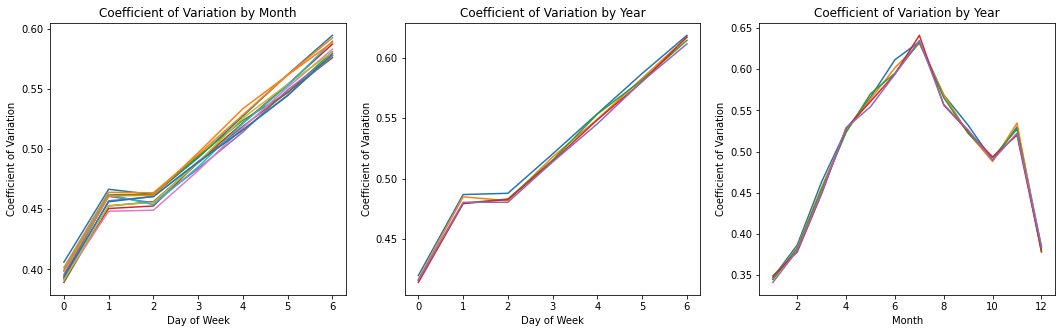

In [11]:
# Aggregate data and calculate standard deviation
std_dow_month = pd.pivot_table(train, index='dayofweek', columns='month', values='sales', aggfunc=np.std)
std_month_year = pd.pivot_table(train, index='month', columns='year', values='sales', aggfunc=np.std)
std_dow_year = pd.pivot_table(train, index='dayofweek', columns='year', values='sales', aggfunc=np.std)

# Normalize the standard deviations by the mean to get a coefficient of variation
cv_dow_month = std_dow_month / train.groupby('month')['sales'].mean()
cv_month_year = std_month_year / train.groupby('year')['sales'].mean()
cv_dow_year = std_dow_year / train.groupby('year')['sales'].mean()

# Plotting
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(cv_dow_month)
plt.title("Coefficient of Variation by Month")
plt.xlabel("Day of Week")
plt.ylabel("Coefficient of Variation")

plt.subplot(133)
plt.plot(cv_month_year)
plt.title("Coefficient of Variation by Year")
plt.xlabel("Month")
plt.ylabel("Coefficient of Variation")

plt.subplot(132)
plt.plot(cv_dow_year)
plt.title("Coefficient of Variation by Year")
plt.xlabel("Day of Week")
plt.ylabel("Coefficient of Variation")

plt.show()


#### Testing for Degeneracies in the Data
- The standard deviation is calculated for each grouping. The standard deviation measures the dispersion of sales, which can be useful in identifying variability in patterns.
- The coefficient of variation is the standard deviation normalized by the mean (a relative measure of dispersion). This provides a dimensionless number that is useful to compare variability across different scales of sales.
- We can observe that the plots show very similar patterns to the relative sales plot in our EDA. This suggests there is no observable degeneracies and we can treat the "month", "year", "day of the week", "item" and "store" as completely independent modifiers to sales prediction. This leads to a very very simple prediction model.

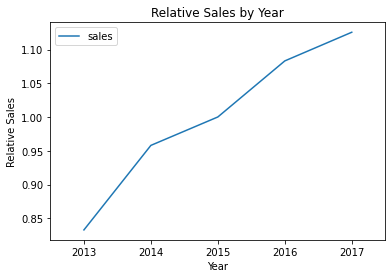

In [12]:
year_table = pd.pivot_table(train, index='year', values='sales', aggfunc=np.mean)/train.sales.mean()
year_table.plot()
# Set the plot limits, title, and labels
plt.xlim(2012.5, 2017.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.legend()  # Display legend to label the data and fits
plt.show()

### Another observation
- We can observe that the relative sales every year is increasing at a decreasing rate. We might want to include this into our factor model too. 
- This means that we need to extrapolate the relative sales in 2018 to come up with the the annual growth factor.
- To write the simple predictor, we want to multiply the historical average of the sales on the day of week and month of the Items X sold at Store Y.

### Extrapolation of Annual Growth Factor in 2018

Let's denote the following:

- Let \( A_{i,s} \) be the historical average sales for item \( i \) at store \( s \).
- Let \( W_d \) be the factor for the day of the week \( d \) (where \( d \) is Monday in your example).
- Let \( M_m \) be the factor for the month \( m \) (February in your example).
- Let \( G_y \) be the annual growth factor for the year \( y \).

Then the predicted sales \( P \) for item \( i \) at store \( s \) on a specific day of the week \( d \) in month \( m \) for year \( y \) can be calculated using the following equation:

$$ P_{i,s,d,m,y} = A_{i,s} \times W_d \times M_m \times G_y $$

Each of the factors \( W_d \), \( M_m \), and \( G_y \) adjusts the historical average \( A_{i,s} \) to account for weekly, monthly, and annual variations in sales.


In [13]:
# split train and validation sets
df_test = train[train["date"] >= "2017-10-01"]
df_train = train[train["date"] < "2017-10-01"]

print(df_train.shape)
print(df_test.shape)

x_train = df_train.drop(columns=["sales", "date"])
y_train = df_train["sales"]
x_test = df_test.drop(columns=["sales", "date"])
y_test = df_test["sales"]

(867000, 13)
(46000, 13)


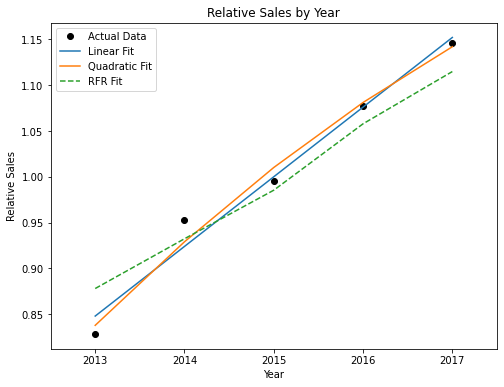

2017 Relative Sales by Linear Fit = 1.1520
2017 Relative Sales by Quadratic Fit = 1.1419
2017 Relative Sales by RFR Fit = 1.0578


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'df_train' is a pandas DataFrame that contains the sales data
# Yearly growth pattern
year_table = pd.pivot_table(df_train, index='year', values='sales', aggfunc=np.mean)
avg = year_table['sales'].mean()

# Calculate the average sales per year
yearly_sales_avg = df_train.groupby('year')['sales'].mean()

# Normalize the yearly sales by the number of weeks in the year for relative sales
relative_sales = yearly_sales_avg / avg

# Prepare the years array for polynomial fitting, excluding the last year
years_fit = np.arange(2013, 2018)
relative_sales_fit = relative_sales.loc[years_fit]

# Define weights, with larger weights for later years. For example, weights could increase linearly
weights = np.exp(np.linspace(0, 5, len(years_fit)))

# Fit polynomial models to the relative sales data
linear_model = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 1))
quadratic_model = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2))

# Fit RFR model to the relative sales data
X = years_fit.reshape(-1, 1)
y = relative_sales_fit.values
rfr = RandomForestRegressor(n_estimators=1000, random_state=0)
rfr.set_params(max_depth=2, min_samples_split=2)
rfr.fit(X, y)

# Prepare a range of years for plotting, including the year to predict
years_plot = np.arange(2013, 2018).reshape(-1, 1)

# Plot the actual relative sales data points
plt.figure(figsize=(8, 6))
plt.plot(years_fit, relative_sales_fit, 'ko', label='Actual Data')

# Plot the fitted linear and quadratic models
plt.plot(years_plot.flatten(), linear_model(years_plot), 'C0-', label='Linear Fit')
plt.plot(years_plot.flatten(), quadratic_model(years_plot), 'C1-', label='Quadratic Fit')

# Plot the RFR model predictions
rfr_predictions = rfr.predict(years_plot)
plt.plot(years_plot.flatten(), rfr_predictions, 'C2--', label='RFR Fit')

# Set the plot limits, title, and labels
plt.xlim(2012.5, 2017.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.legend()  # Display legend to label the data and fits
plt.show()

# Predict the relative sales for 2017 using both polynomial models
linear_prediction_2017 = linear_model(2017)
quadratic_prediction_2017 = quadratic_model(2017)
rfr_prediction_2017 = rfr_predictions[-2]  # Second last position for 2017

# Print the predictions for 2017
print(f"2017 Relative Sales by Linear Fit = {linear_prediction_2017:.4f}")
print(f"2017 Relative Sales by Quadratic Fit = {quadratic_prediction_2017:.4f}")
print(f"2017 Relative Sales by RFR Fit = {rfr_prediction_2017:.4f}")


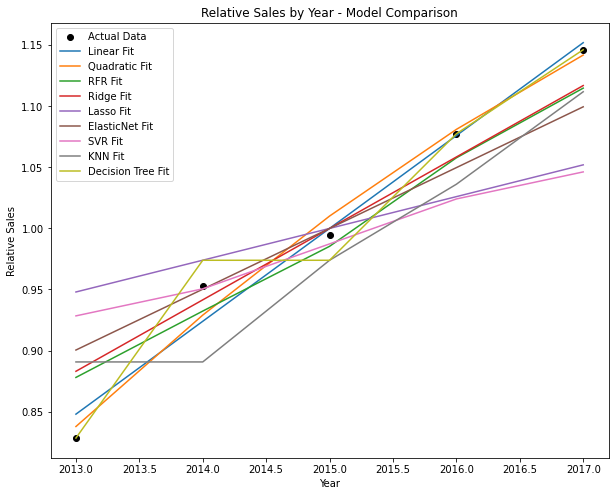

2017 Relative Sales by Linear Fit = 1.1520
2017 Relative Sales by Quadratic Fit = 1.1419
2017 Relative Sales by RFR Fit = 1.0578
2017 Relative Sales by Ridge Fit = 1.1170
2017 Relative Sales by Lasso Fit = 1.0520
2017 Relative Sales by ElasticNet Fit = 1.0995
2017 Relative Sales by SVR Fit = 1.0463
2017 Relative Sales by KNN Fit = 1.1119
2017 Relative Sales by Decision Tree Fit = 1.1463


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# Initialize models
ridge_reg = Ridge(alpha=3.0)
lasso_reg = Lasso(alpha=0.1)
elastic_net_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
svr_reg = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
knn_reg = KNeighborsRegressor(n_neighbors=2)
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=0)

# Fit the models
ridge_reg.fit(X, y)
lasso_reg.fit(X, y)
elastic_net_reg.fit(X, y)
svr_reg.fit(X, y)
knn_reg.fit(X, y)
tree_reg.fit(X, y)

# Predict with all models for the plot
ridge_predictions = ridge_reg.predict(years_plot)
lasso_predictions = lasso_reg.predict(years_plot)
elastic_net_predictions = elastic_net_reg.predict(years_plot)
svr_predictions = svr_reg.predict(years_plot)
knn_predictions = knn_reg.predict(years_plot)
tree_predictions = tree_reg.predict(years_plot)

# Plot all the predictions
plt.figure(figsize=(10, 8))
plt.scatter(years_fit, y, color='black', label='Actual Data')
plt.plot(years_plot, linear_model(years_plot), label='Linear Fit')
plt.plot(years_plot, quadratic_model(years_plot), label='Quadratic Fit')
plt.plot(years_plot, rfr_predictions, label='RFR Fit')
plt.plot(years_plot, ridge_predictions, label='Ridge Fit')
plt.plot(years_plot, lasso_predictions, label='Lasso Fit')
plt.plot(years_plot, elastic_net_predictions, label='ElasticNet Fit')
plt.plot(years_plot, svr_predictions, label='SVR Fit')
plt.plot(years_plot, knn_predictions, label='KNN Fit')
plt.plot(years_plot, tree_predictions, label='Decision Tree Fit')

plt.title('Relative Sales by Year - Model Comparison')
plt.xlabel('Year')
plt.ylabel('Relative Sales')
plt.legend()
plt.show()

# Print predictions for 2017 using all models
print(f"2017 Relative Sales by Linear Fit = {linear_prediction_2017:.4f}")
print(f"2017 Relative Sales by Quadratic Fit = {quadratic_prediction_2017:.4f}")
print(f"2017 Relative Sales by RFR Fit = {rfr_prediction_2017:.4f}")
print(f"2017 Relative Sales by Ridge Fit = {ridge_predictions[-1]:.4f}")
print(f"2017 Relative Sales by Lasso Fit = {lasso_predictions[-1]:.4f}")
print(f"2017 Relative Sales by ElasticNet Fit = {elastic_net_predictions[-1]:.4f}")
print(f"2017 Relative Sales by SVR Fit = {svr_predictions[-1]:.4f}")
print(f"2017 Relative Sales by KNN Fit = {knn_predictions[-1]:.4f}")
print(f"2017 Relative Sales by Decision Tree Fit = {tree_predictions[-1]:.4f}")


In [16]:
norm_agg_week_item = df_train.pivot_table(index='dayofweek', values='sales', aggfunc='mean')/avg
norm_agg_month_item = df_train.pivot_table(index='month', values='sales', aggfunc='mean')/avg
norm_agg_year_sales = df_train.pivot_table(index='year', values='sales', aggfunc='mean')/avg
norm_agg_year_store = df_train.pivot_table(index='store', values='sales', aggfunc='mean')/avg
norm_agg_year_item = df_train.pivot_table(index='item', values='sales', aggfunc='mean')/avg
store_item_table = df_train.pivot_table(index='store', columns='item', values='sales', aggfunc='mean')

In [17]:
agg_week_item = df_train.pivot_table(index='dayofweek', columns='item', values='sales', aggfunc='mean')
agg_week_item

item              1          2          3          4          5          6   \
dayofweek                                                                     
0          17.431579  46.127935  29.000405  17.419838  14.440081  46.287045   
1          20.237903  54.122177  33.653226  20.294355  16.785484  53.711694   
2          20.392742  54.013306  33.860081  20.327016  17.015726  53.908468   
3          21.611290  57.945161  36.018548  21.747581  18.168548  57.632661   
4          23.209274  61.822177  38.718145  23.197177  19.462500  61.607661   
5          24.646371  65.646774  41.099597  24.674597  20.506452  65.799194   
6          25.984211  69.406073  43.417814  26.053036  21.774494  69.677733   

item              7          8          9          10  ...         41  \
dayofweek                                              ...              
0          46.172874  60.670040  40.881781  57.848988  ...  17.428340   
1          53.930242  70.981452  47.411290  67.247984  ...  20.302419   
2          54.079435  70.843548  47.393145  67.741935  ...  20.349194   
3          57.997984  75.749194  50.506048  72.191532  ...  21.610081   
4          61.483468  81.005645  54.134274  77.303629  ...  23.328226   
5          65.562903  86.431855  57.586290  82.117339  ...  24.548790   
6          69.472874  91.460324  61.130364  86.805263  ...  26.154251   

item              42         43         44         45         46         47  \
dayofweek                                                                     
0          28.890283  40.748178  23.143320  63.605263  46.450607  17.420648   
1          33.825000  46.904839  27.240726  73.996371  53.922984  20.242339   
2          33.921371  47.413710  26.979032  74.337903  53.848790  20.399597   
3          36.262500  50.690726  28.935887  79.500000  57.759677  21.685887   
4          38.596774  54.086290  30.981048  85.289113  62.197581  23.052823   
5          41.091935  57.236290  33.064113  90.438306  65.556048  24.776210   
6          43.665992  60.978947  34.895142  95.618623  69.594737  26.085425   

item              48         49         50  
dayofweek                                   
0          40.584211  23.257085  52.212551  
1          46.993145  26.948790  60.504032  
2          47.314516  27.093952  61.051210  
3          50.540726  29.104032  65.354839  
4          54.467339  30.968145  69.315726  
5          57.422984  32.785081  73.807661  
6          61.155061  34.806478  77.990283  

[7 rows x 50 columns]

In [18]:
def pred(test, store_item_table, norm_agg_week_item, norm_agg_month_item, norm_annual_growth):
    predictions = []
    for col, row in test.iterrows():
        the_date = pd.to_datetime(row['date'], infer_datetime_format=True)
        week,month,year = the_date.dayofweek, the_date.month, the_date.year
        item, store = row['item'], row['store']
        # average of store,item as base value
        base_sales = store_item_table.at[store,item] 
        multiplier = norm_agg_week_item.at[week, 'sales'] * norm_agg_month_item.at[month, 'sales']
        pred = base_sales * multiplier * norm_annual_growth
        predictions.append(int(pred))
    return predictions

In [19]:
# Generate predictions for each model
pred_linear_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, linear_prediction_2017)
pred_quadratic_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017)
pred_rfr_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, rfr_prediction_2017)
pred_ridge_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, ridge_predictions[-1])
pred_lasso_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, lasso_predictions[-1])
pred_elastic_net_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, elastic_net_predictions[-1])
pred_svr_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, svr_predictions[-1])
pred_knn_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, knn_predictions[-1])
pred_decision_tree_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, tree_predictions[-1])


# Generate predictions for each model
pred_linear = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, linear_prediction_2017)
pred_quadratic = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017)
pred_rfr = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, rfr_prediction_2017)
pred_ridge = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, ridge_predictions[-1])
pred_lasso = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, lasso_predictions[-1])
pred_elastic_net = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, elastic_net_predictions[-1])
pred_svr = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, svr_predictions[-1])
pred_knn = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, knn_predictions[-1])
pred_decision_tree = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, tree_predictions[-1])

In [45]:
y_true_train = y_train.values
y_true = df_test.sales.values

# Calculate TRAIN SMAPE for all models
linear_smape_train = calculate_smape(y_true_train, pred_linear_train)
quad_smape_train = calculate_smape(y_true_train, pred_quadratic_train)
# rfr_smape_train = calculate_smape(y_true_train, pred_rfr_train)
ridge_smape_train = calculate_smape(y_true_train, pred_ridge_train)
lasso_smape_train = calculate_smape(y_true_train, pred_lasso_train)
elastic_net_smape_train = calculate_smape(y_true_train, pred_elastic_net_train)
svr_smape_train = calculate_smape(y_true_train, pred_svr_train)
# knn_smape_train = calculate_smape(y_true_train, pred_knn_train)
# decision_tree_smape_train = calculate_smape(y_true_train, pred_decision_tree_train)

# Calculate TEST SMAPE for all models
linear_smape = calculate_smape(y_true, pred_linear)
quad_smape = calculate_smape(y_true, pred_quadratic)
# rfr_smape = calculate_smape(y_true, pred_rfr)
ridge_smape = calculate_smape(y_true, pred_ridge)
lasso_smape = calculate_smape(y_true, pred_lasso)
elastic_net_smape = calculate_smape(y_true, pred_elastic_net)
svr_smape = calculate_smape(y_true, pred_svr)
knn_smape = calculate_smape(y_true, pred_knn)
decision_tree_smape = calculate_smape(y_true, pred_decision_tree)

# Print the SMAPE values for all models
print('TRAIN SMAPE')
print(f"TRAIN SMAPE for Linear Regression: {linear_smape_train:.2f}%")
print(f"TRAIN SMAPE for Quadratic Regression: {quad_smape_train:.2f}%")
# print(f"TRAIN SMAPE for Random Forest Regression: {rfr_smape_train:.2f}%")
print(f"TRAIN SMAPE for Ridge Regression: {ridge_smape_train:.2f}%")
print(f"TRAIN SMAPE for Lasso Regression: {lasso_smape_train:.2f}%")
print(f"TRAIN SMAPE for ElasticNet Regression: {elastic_net_smape_train:.2f}%")
print(f"TRAIN SMAPE for SVR: {svr_smape_train:.2f}%")
# print(f"TRAIN SMAPE for KNN Regression: {knn_smape_train:.2f}%")
# print(f"TRAIN SMAPE for Decision Tree Regression: {decision_tree_smape_train:.2f}%")

print('\nTEST SMAPE')
print(f"TEST SMAPE for Linear Regression: {linear_smape:.2f}%")
print(f"TEST SMAPE for Quadratic Regression: {quad_smape:.2f}%")
# print(f"TEST SMAPE for Random Forest Regression: {rfr_smape:.2f}%")
print(f"TEST SMAPE for Ridge Regression: {ridge_smape:.2f}%")
print(f"TEST SMAPE for Lasso Regression: {lasso_smape:.2f}%")
print(f"TEST SMAPE for ElasticNet Regression: {elastic_net_smape:.2f}%")
print(f"TEST SMAPE for SVR: {svr_smape:.2f}%")
# print(f"TEST SMAPE for KNN Regression: {knn_smape:.2f}%")
# print(f"TEST SMAPE for Decision Tree Regression: {decision_tree_smape:.2f}%")

TRAIN SMAPE
TRAIN SMAPE for Linear Regression: 18.12%
TRAIN SMAPE for Quadratic Regression: 17.69%
TRAIN SMAPE for Ridge Regression: 16.77%
TRAIN SMAPE for Lasso Regression: 15.30%
TRAIN SMAPE for ElasticNet Regression: 16.23%
TRAIN SMAPE for SVR: 15.24%

TEST SMAPE
TEST SMAPE for Linear Regression: 12.43%
TEST SMAPE for Quadratic Regression: 12.61%
TEST SMAPE for Ridge Regression: 13.23%
TEST SMAPE for Lasso Regression: 16.04%
TEST SMAPE for ElasticNet Regression: 13.81%
TEST SMAPE for SVR: 16.38%


From the above values of SMAPE being calculated, it seems that linear, quadratic and Decision Tree are the possible choices (<13 SMAPE). Let's plot do the same fit with all our data to observe.

In [21]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

In [22]:
def add_features(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    
    df['item_monthly_avg'] = df.groupby(['item', 'month'])['sales'].transform('mean').astype(np.int64)
    df['store_monthly_avg'] = df.groupby(['store', 'month'])['sales'].transform('mean').astype(np.int64)
    df['item_yearly_avg'] = df.groupby(['item', 'year'])['sales'].transform('mean').astype(np.int64)
    df['store_yearly_avg'] = df.groupby(['store', 'year'])['sales'].transform('mean').astype(np.int64)
    return df

In [23]:
df = add_features(train)
df.head(10)

date  store  item  sales  day  month  year  dayofweek  quarter  \
0 2013-01-01      1     1     13    1      1  2013          1        1   
1 2013-01-02      1     1     11    2      1  2013          2        1   
2 2013-01-03      1     1     14    3      1  2013          3        1   
3 2013-01-04      1     1     13    4      1  2013          4        1   
4 2013-01-05      1     1     10    5      1  2013          5        1   
5 2013-01-06      1     1     12    6      1  2013          6        1   
6 2013-01-07      1     1     10    7      1  2013          0        1   
7 2013-01-08      1     1      9    8      1  2013          1        1   
8 2013-01-09      1     1     12    9      1  2013          2        1   
9 2013-01-10      1     1      9   10      1  2013          3        1   

   item_monthly_avg  store_monthly_avg  item_yearly_avg  store_yearly_avg  
0                14                 32               18                39  
1                14                 32               18                39  
2                14                 32               18                39  
3                14                 32               18                39  
4                14                 32               18                39  
5                14                 32               18                39  
6                14                 32               18                39  
7                14                 32               18                39  
8                14                 32               18                39  
9                14                 32               18                39

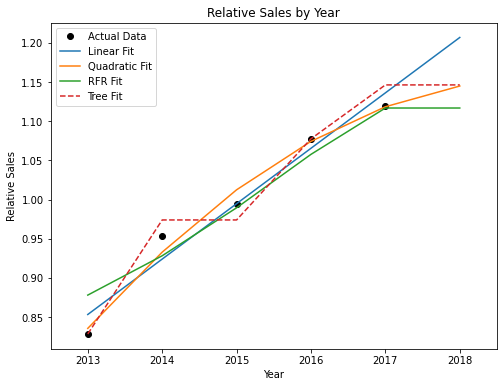

2018 Relative Sales by Linear Fit = 1.2068
2018 Relative Sales by Quadratic Fit = 1.1448
2018 Relative Sales by RFR Fit = 1.1168
2018 Relative Sales by Decision Tree Fit = 1.1463


In [24]:
# Calculate the average sales per year
yearly_sales_avg = df.groupby('year')['sales'].mean()

# Normalize the yearly sales by the number of weeks in the year for relative sales
relative_sales = yearly_sales_avg / avg

# Prepare the years array for polynomial fitting, excluding the last year
years_fit = np.arange(2013, 2018)
relative_sales_fit = relative_sales.loc[years_fit]

# Fit polynomial models to the relative sales data
linear_model = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 1))
quadratic_model = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2))

rfr = RandomForestRegressor(n_estimators=1000, random_state=0)
rfr.set_params(max_depth=4, min_samples_split=2)
rfr.fit(years_fit.reshape(-1,1), y)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(years_fit.reshape(-1,1), y)

# Prepare a range of years for plotting, including the year to predict
years_plot = np.arange(2013, 2019)

# Plot the actual relative sales data points
plt.figure(figsize=(8, 6))
plt.plot(years_fit, relative_sales_fit, 'ko', label='Actual Data')

# Plot the fitted linear and quadratic models
plt.plot(years_plot, linear_model(years_plot), 'C0-', label='Linear Fit')
plt.plot(years_plot, quadratic_model(years_plot), 'C1-', label='Quadratic Fit')
plt.plot(years_plot, rfr.predict(years_plot.reshape(-1,1)), 'C2-', label='RFR Fit')
plt.plot(years_plot, tree_reg.predict(years_plot.reshape(-1,1)), 'C3--', label='Tree Fit')

# Set the plot limits, title, and labels
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.legend()  # Display legend to label the data and fits
plt.show()

# Predict the relative sales for 2018 using both polynomial models
linear_prediction_2018 = linear_model(2018)
quadratic_prediction_2018 = quadratic_model(2018)
rfr_prediction_2018 = rfr.predict(years_plot.reshape(-1,1))[-1]
tree_prediction_2018 = tree_reg.predict(years_plot.reshape(-1,1))[-1]

# Print the predictions for 2018
print(f"2018 Relative Sales by Linear Fit = {linear_prediction_2018:.4f}")
print(f"2018 Relative Sales by Quadratic Fit = {quadratic_prediction_2018:.4f}")
print(f"2018 Relative Sales by RFR Fit = {rfr_prediction_2018:.4f}")
print(f"2018 Relative Sales by Decision Tree Fit = {tree_prediction_2018:.4f}")


### Observations
- We can almost immediately see that the quadratic fit seems to give the best fit amongs the 4 regressors
- There seem to be a slight taper off as we move in years and the error from the linear regression seems to be increasing in this case.
- RFR and Decision Tree seems to be an overfit due to the small number of data points.

Next: Add a weight to the Quadratic fit

In [25]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

train = add_features(train)

In [26]:
# split train and validation sets
df_test = train[train["date"] >= "2017-10-01"]
df_train = train[train["date"] < "2017-10-01"]

print(df_train.shape)
print(df_test.shape)

x_train = df_train.drop(columns=["sales"])
y_train = df_train["sales"]
x_test = df_test.drop(columns=["sales"])
y_test = df_test["sales"]

(867000, 13)
(46000, 13)


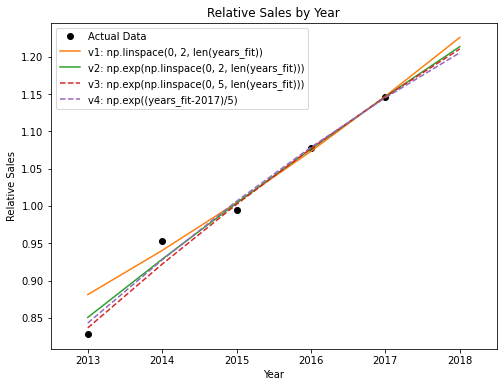

2017 Relative Sales by Quadratic Fit v1 = 1.1471
2017 Relative Sales by Quadratic Fit v2 = 1.1463
2017 Relative Sales by Quadratic Fit v3 = 1.1463
2017 Relative Sales by Quadratic Fit v4 = 1.1450


In [27]:
# Assuming 'df_train' is a pandas DataFrame that contains the sales data
# Yearly growth pattern
year_table = pd.pivot_table(df_train, index='year', values='sales', aggfunc=np.mean)
avg = year_table['sales'].mean()

# Calculate the average sales per year
yearly_sales_avg = df_train.groupby('year')['sales'].mean()

# Normalize the yearly sales by the number of weeks in the year for relative sales
relative_sales = yearly_sales_avg / avg

# Prepare the years array for polynomial fitting, excluding the last year
years_fit = np.arange(2013, 2018)
relative_sales_fit = relative_sales.loc[years_fit]

# Different weights
w1 = np.linspace(0, 2, len(years_fit))
w2 = np.exp(np.linspace(0, 2, len(years_fit)))
w3 = np.exp(np.linspace(0, 5, len(years_fit)))
w4 = np.exp((years_fit-2017)/5)

# Fit polynomial models to the relative sales data
quadratic_model_1 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w1))
quadratic_model_2 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w2))
quadratic_model_3 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w3))
quadratic_model_4 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w4))

# Prepare a range of years for plotting, including the year to predict
years_plot = np.arange(2013, 2019)

# Plot the actual relative sales data points
plt.figure(figsize=(8, 6))
plt.plot(years_fit, relative_sales_fit, 'ko', label='Actual Data')

# Plot the fitted linear and quadratic models
plt.plot(years_plot, quadratic_model_1(years_plot), 'C1-', label='v1: np.linspace(0, 2, len(years_fit))')
plt.plot(years_plot, quadratic_model_2(years_plot), 'C2-', label='v2: np.exp(np.linspace(0, 2, len(years_fit)))')
plt.plot(years_plot, quadratic_model_3(years_plot), 'C3--', label='v3: np.exp(np.linspace(0, 5, len(years_fit)))')
plt.plot(years_plot, quadratic_model_4(years_plot), 'C4--', label='v4: np.exp((years_fit-2017)/5)')

# Set the plot limits, title, and labels
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.legend()  # Display legend to label the data and fits
plt.show()

# Predict the relative sales for 2018 using both polynomial models
quadratic_prediction_2017_1 = quadratic_model_1(2017)
quadratic_prediction_2017_2 = quadratic_model_2(2017)
quadratic_prediction_2017_3 = quadratic_model_3(2017)
quadratic_prediction_2017_4 = quadratic_model_4(2017)


# Print the predictions for 2018
print(f"2017 Relative Sales by Quadratic Fit v1 = {quadratic_prediction_2017_1:.4f}")
print(f"2017 Relative Sales by Quadratic Fit v2 = {quadratic_prediction_2017_2:.4f}")
print(f"2017 Relative Sales by Quadratic Fit v3 = {quadratic_prediction_2017_3:.4f}")
print(f"2017 Relative Sales by Quadratic Fit v4 = {quadratic_prediction_2017_4:.4f}")

In [28]:
norm_agg_week_item = df_train.pivot_table(index='dayofweek', values='sales', aggfunc='mean')/avg
norm_agg_month_item = df_train.pivot_table(index='month', values='sales', aggfunc='mean')/avg
norm_agg_year_sales = df_train.pivot_table(index='year', values='sales', aggfunc='mean')/avg
norm_agg_year_store = df_train.pivot_table(index='store', values='sales', aggfunc='mean')/avg
norm_agg_year_item = df_train.pivot_table(index='item', values='sales', aggfunc='mean')/avg
store_item_table = df_train.pivot_table(index='store', columns='item', values='sales', aggfunc='mean')

In [29]:
pred_quadratic_1_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_1)
pred_quadratic_2_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_2)
pred_quadratic_3_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_3)
pred_quadratic_4_train = pred(df_train, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_4)

pred_quadratic_1 = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_1)
pred_quadratic_2 = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_2)
pred_quadratic_3 = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_3)
pred_quadratic_4 = pred(df_test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2017_4)

In [37]:
from sklearn.metrics import mean_absolute_error

In [40]:
y_true_train = y_train.values
y_true = df_test.sales.values

quad_smape_1_train = calculate_smape(y_true_train, pred_quadratic_1_train)
quad_smape_2_train = calculate_smape(y_true_train, pred_quadratic_2_train)
quad_smape_3_train = calculate_smape(y_true_train, pred_quadratic_3_train)
quad_smape_4_train = calculate_smape(y_true_train, pred_quadratic_4_train)

quad_smape_1 = calculate_smape(y_true, pred_quadratic_1)
quad_smape_2 = calculate_smape(y_true, pred_quadratic_2)
quad_smape_3 = calculate_smape(y_true, pred_quadratic_3)
quad_smape_4 = calculate_smape(y_true, pred_quadratic_4)

print('TRAIN SMAPE')
print(f"TRAIN SMAPE for Quadratic Regression: {quad_smape_1_train:.2f}%")
print(f"TRAIN SMAPE for Quadratic Regression: {quad_smape_2_train:.2f}%")
print(f"TRAIN SMAPE for Quadratic Regression: {quad_smape_3_train:.2f}%")
print(f"TRAIN SMAPE for Quadratic Regression: {quad_smape_4_train:.2f}%")

print('\nTEST SMAPE')
print(f"TEST SMAPE for Quadratic Regression: {quad_smape_1:.2f}%")
print(f"TEST SMAPE for Quadratic Regression: {quad_smape_2:.2f}%")
print(f"TEST SMAPE for Quadratic Regression: {quad_smape_3:.2f}%")
print(f"TEST SMAPE for Quadratic Regression: {quad_smape_4:.2f}%")

TRAIN SMAPE
TRAIN SMAPE for Quadratic Regression: 17.91%
TRAIN SMAPE for Quadratic Regression: 17.88%
TRAIN SMAPE for Quadratic Regression: 17.88%
TRAIN SMAPE for Quadratic Regression: 17.83%

TEST SMAPE
TEST SMAPE for Quadratic Regression: 12.51%
TEST SMAPE for Quadratic Regression: 12.53%
TEST SMAPE for Quadratic Regression: 12.53%
TEST SMAPE for Quadratic Regression: 12.55%


### Whole dataset to produce a prediction

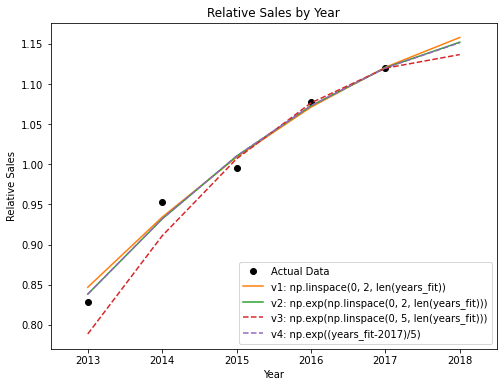

2018 Relative Sales by Quadratic Fit v1 = 1.1580
2018 Relative Sales by Quadratic Fit v2 = 1.1522
2018 Relative Sales by Quadratic Fit v3 = 1.1367
2018 Relative Sales by Quadratic Fit v4 = 1.1515


In [32]:
# Calculate the average sales per year
yearly_sales_avg = df.groupby('year')['sales'].mean()

# Normalize the yearly sales by the number of weeks in the year for relative sales
relative_sales = yearly_sales_avg / avg

# Prepare the years array for polynomial fitting, excluding the last year
years_fit = np.arange(2013, 2018)
relative_sales_fit = relative_sales.loc[years_fit]

# Different weights
w1 = np.linspace(0, 2, len(years_fit))
w2 = np.exp(np.linspace(0, 2, len(years_fit)))
w3 = np.exp(np.linspace(0, 5, len(years_fit)))
w4 = np.exp((years_fit-2017)/5)

# Fit polynomial models to the relative sales data
quadratic_model_1 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w1))
quadratic_model_2 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w2))
quadratic_model_3 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w3))
quadratic_model_4 = np.poly1d(np.polyfit(years_fit, relative_sales_fit, 2, w=w4))

# Prepare a range of years for plotting, including the year to predict
years_plot = np.arange(2013, 2019)

# Plot the actual relative sales data points
plt.figure(figsize=(8, 6))
plt.plot(years_fit, relative_sales_fit, 'ko', label='Actual Data')

# Plot the fitted linear and quadratic models
plt.plot(years_plot, quadratic_model_1(years_plot), 'C1-', label='v1: np.linspace(0, 2, len(years_fit))')
plt.plot(years_plot, quadratic_model_2(years_plot), 'C2-', label='v2: np.exp(np.linspace(0, 2, len(years_fit)))')
plt.plot(years_plot, quadratic_model_3(years_plot), 'C3--', label='v3: np.exp(np.linspace(0, 5, len(years_fit)))')
plt.plot(years_plot, quadratic_model_4(years_plot), 'C4--', label='v4: np.exp((years_fit-2017)/5)')


# Set the plot limits, title, and labels
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.legend()  # Display legend to label the data and fits
plt.show()

# Predict the relative sales for 2018 using both polynomial models
quadratic_prediction_2018_1 = quadratic_model_1(2018)
quadratic_prediction_2018_2 = quadratic_model_2(2018)
quadratic_prediction_2018_3 = quadratic_model_3(2018)
quadratic_prediction_2018_4 = quadratic_model_4(2018)


# Print the predictions for 2018
print(f"2018 Relative Sales by Quadratic Fit v1 = {quadratic_prediction_2018_1:.4f}")
print(f"2018 Relative Sales by Quadratic Fit v2 = {quadratic_prediction_2018_2:.4f}")
print(f"2018 Relative Sales by Quadratic Fit v3 = {quadratic_prediction_2018_3:.4f}")
print(f"2018 Relative Sales by Quadratic Fit v4 = {quadratic_prediction_2018_4:.4f}")



### Predictions

In [33]:
def pred(test, store_item_table, norm_agg_week_item, norm_agg_month_item, norm_annual_growth):
    predictions = []
    for col, row in test.iterrows():
        the_date = pd.to_datetime(row['date'], infer_datetime_format=True)
        week,month,year = the_date.dayofweek, the_date.month, the_date.year
        item, store = row['item'], row['store']
        # average of store,item as base value
        base_sales = store_item_table.at[store,item] 
        multiplier = norm_agg_week_item.at[week, 'sales'] * norm_agg_month_item.at[month, 'sales']
        pred = base_sales * multiplier * norm_annual_growth
        predictions.append(pred)
        
    return predictions

In [34]:
norm_agg_week_item = df_train.pivot_table(index='dayofweek', values='sales', aggfunc='mean')/avg
norm_agg_month_item = df_train.pivot_table(index='month', values='sales', aggfunc='mean')/avg
norm_agg_year_sales = df_train.pivot_table(index='year', values='sales', aggfunc='mean')/avg
norm_agg_year_store = df_train.pivot_table(index='store', values='sales', aggfunc='mean')/avg
norm_agg_year_item = df_train.pivot_table(index='item', values='sales', aggfunc='mean')/avg
store_item_table = df_train.pivot_table(index='store', columns='item', values='sales', aggfunc='mean')

In [35]:
# predictions = pred2(test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2018_w)
predictions_1 = pred(test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2018_1)
predictions_2 = pred(test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2018_2)
predictions_3 = pred(test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2018_3)
predictions_4 = pred(test, store_item_table, norm_agg_week_item, norm_agg_month_item, quadratic_prediction_2018_4)

After submission:
We observe that v3 produced the best SMAPE of 13.88.